### Creating a simple recommendation system in Python using Pandas as it is done in the following example.

### Data:

### First, you need to download your *data for recommendation systems* from one of these repositories:
- BX-Dump https://github.com/bigsnarfdude/guide-to-data-mining/tree/master/BX-Dump [**this is the dataset used here**]
- Amazon review data http://jmcauley.ucsd.edu/data/amazon/ 
- Bookcrossing http://www2.informatik.uni-freiburg.de/~cziegler/BX/
- SNAP Amazon reviews https://snap.stanford.edu/data/web-Amazon.html
- MovieLens https://grouplens.org/
- Trending YouTube Video (kaggle) https://www.kaggle.com/datasnaek/youtube
- Or anywhere else you might be able to locate data similar to the ones processed in this notebook.


### The ideal size of the selected dataset should be in between 0.3M and 1M. 

In [30]:
import pandas as pd
import numpy as np
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
import matplotlib.pyplot as plt
from pylab import hist
import random
from collections import Counter
import operator
import itertools
import cPickle as pickle
import warnings
warnings.filterwarnings("ignore")

import gzip
import matplotlib.dates as mdates

In [31]:
#Using Amazon review data on Toys and Games from http://jmcauley.ucsd.edu/data/amazon/


def parse(path):
    g = gzip.open(path, 'rb')
    for l in g: 
        yield eval(l) 

def getDF(path):
    i = 0 
    df = {} 
    for d in parse(path):
        df[i] = d
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 
    
df = getDF('reviews_Toys_and_Games_5.json.gz')

In [32]:
print df.shape
print list(df.columns)
print sorted(list(df.overall.unique()))
df.head()

(167597, 9)
['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewText', 'overall', 'reviewTime', 'summary']
[1.0, 2.0, 3.0, 4.0, 5.0]


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1VXOAVRGKGEAK,0439893577,Angie,"[0, 0]",1390953600,I like the item pricing. My granddaughter want...,5.0,"01 29, 2014",Magnetic board
1,A8R62G708TSCM,0439893577,Candace,"[1, 1]",1395964800,Love the magnet easel... great for moving to d...,4.0,"03 28, 2014",it works pretty good for moving to different a...
2,A21KH420DK0ICA,0439893577,capemaychristy,"[1, 1]",1359331200,Both sides are magnetic. A real plus when you...,5.0,"01 28, 2013",love this!
3,AR29QK6HPFYZ4,0439893577,dcrm,"[0, 0]",1391817600,Bought one a few years ago for my daughter and...,5.0,"02 8, 2014",Daughters love it
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",1399248000,I have a stainless steel refrigerator therefor...,4.0,"05 5, 2014",Great to have so he can play with his alphabet...


### 1. Ratings

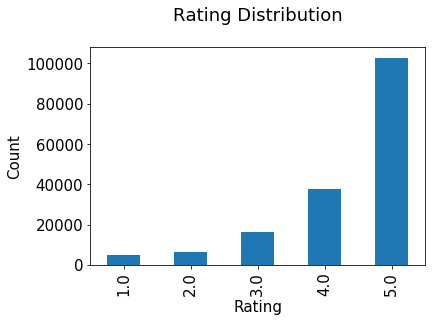

In [33]:
plt.rc("font", size=15)
df.overall.value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### 2. Reviewers

In [34]:
df['reviewTime'].dtype

dtype('O')

In [35]:
#change reviewTime from object to date
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df.head()

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1VXOAVRGKGEAK,0439893577,Angie,"[0, 0]",1390953600,I like the item pricing. My granddaughter want...,5.0,2014-01-29,Magnetic board
1,A8R62G708TSCM,0439893577,Candace,"[1, 1]",1395964800,Love the magnet easel... great for moving to d...,4.0,2014-03-28,it works pretty good for moving to different a...
2,A21KH420DK0ICA,0439893577,capemaychristy,"[1, 1]",1359331200,Both sides are magnetic. A real plus when you...,5.0,2013-01-28,love this!
3,AR29QK6HPFYZ4,0439893577,dcrm,"[0, 0]",1391817600,Bought one a few years ago for my daughter and...,5.0,2014-02-08,Daughters love it
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",1399248000,I have a stainless steel refrigerator therefor...,4.0,2014-05-05,Great to have so he can play with his alphabet...


#### 2.1 Reviewers and the Year the Rating was Submitted

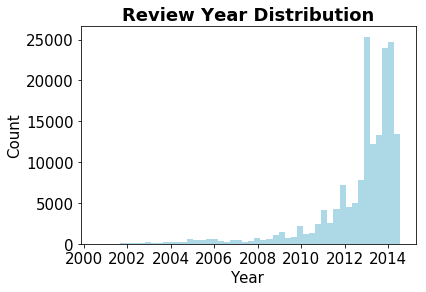

In [36]:
fig, ax = plt.subplots(1,1)
ax.hist(df['reviewTime'], bins=50, color ='lightblue')
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
plt.title('Review Year Distribution', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [37]:
uc=Counter(df['reviewTime'])
lc=[]
xc=[]
for k in sorted(uc):
    xc.append(k)
    lc.append(uc[k])
#     print k,uc[k]

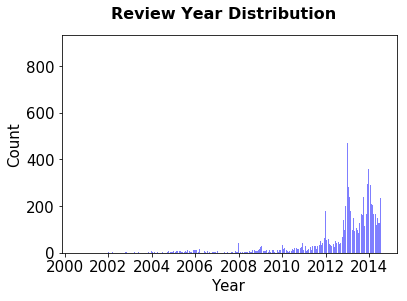

In [38]:
ax = plt.subplot(111)
hh=ax.bar(xc, lc,color="blue", alpha=0.5); #range=[10,284],range=[0,100],
ntei="Review Year Distribution"
# for p in ax.patches:
#     ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points',fontsize=9)
t1=plt.suptitle(ntei,fontsize=16,fontweight='bold');
t1=plt.xlabel("Year", fontsize=15);
t1=plt.ylabel("Count", fontsize=15);

### 3.  Toys

In [39]:
print df.shape
print list(df.columns)
df.head()

(167597, 9)
['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewText', 'overall', 'reviewTime', 'summary']


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1VXOAVRGKGEAK,0439893577,Angie,"[0, 0]",1390953600,I like the item pricing. My granddaughter want...,5.0,2014-01-29,Magnetic board
1,A8R62G708TSCM,0439893577,Candace,"[1, 1]",1395964800,Love the magnet easel... great for moving to d...,4.0,2014-03-28,it works pretty good for moving to different a...
2,A21KH420DK0ICA,0439893577,capemaychristy,"[1, 1]",1359331200,Both sides are magnetic. A real plus when you...,5.0,2013-01-28,love this!
3,AR29QK6HPFYZ4,0439893577,dcrm,"[0, 0]",1391817600,Bought one a few years ago for my daughter and...,5.0,2014-02-08,Daughters love it
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",1399248000,I have a stainless steel refrigerator therefor...,4.0,2014-05-05,Great to have so he can play with his alphabet...


### 4. Recommendations Based on Toy Rating Counts

#### 4.1 Toy Rating

In [40]:
#toy is indicated by ASIN. No toy titles or toy descriptions exist in dataset
rating_count = pd.DataFrame(df.groupby('asin')['overall'].count())
rating_count.sort_values('overall', ascending=False).head()

,overall
asin,
B004S8F7QM,309
B0089RPUHO,253
B0039S7NO6,215
B001W30D2O,207
B002NPBT50,196


#### 4.2 Most Rated Toys

In [41]:
most_rated_toys = pd.DataFrame(['B004S8F7QM', 'B0089RPUHO', 'B0039S7NO6', 'B001W30D2O', 'B002NPBT50'], index=np.arange(5), columns = ['asin'])
most_rated_toys_summary = pd.merge(most_rated_toys, df, on='asin')
most_rated_toys_summary

,asin,reviewerID,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,B004S8F7QM,A1KN44W6LWBM0X,NaN,"[0, 0]",1366761600,A group of friends and I sat down with a few g...,5.0,2013-04-24,Laughed till it hurt
1,B004S8F7QM,A2YTL3NDH6JAHA,NaN,"[0, 0]",1369699200,As my 28 y/o daughter said throughout her firs...,5.0,2013-05-28,After the first 3 hands you'll either love it ...
2,B004S8F7QM,A66XJOWNNVFMX,NaN,"[0, 0]",1374710400,"at first but was lots of fun, but maybe that's...",5.0,2013-07-25,Sounded stupid
3,B004S8F7QM,AEOYYDTJM0JI3,NaN,"[0, 0]",1360972800,"Bewst game ever! And I hate games, but I WILL...",5.0,2013-02-16,Cards against Humanity
4,B004S8F7QM,A2TE44DT7N8A0V,NaN,"[0, 0]",1357344000,Bought this book after reading the reviews on ...,5.0,2013-01-05,Naughty and hilarious game
5,B004S8F7QM,AGIR4MLM5NFRZ,NaN,"[0, 0]",1356998400,Bought this for my brother for Christmas and h...,5.0,2013-01-01,Makes me feel guilty that I find some of these...
6,B004S8F7QM,A12COGFVG1CX2W,NaN,"[0, 0]",1372982400,By far the best adult card game ever!!!! Well ...,5.0,2013-07-05,Amazing
7,B004S8F7QM,A26YLUNHR2RZ6N,NaN,"[0, 0]",1356825600,Cards Against Humanity is such a fun game. It...,5.0,2012-12-30,Love this game!
8,B004S8F7QM,AR3BJLN57A14B,NaN,"[0, 0]",1363651200,Cards Against Humanity is the best social game...,5.0,2013-03-19,BEST GAME EVER
9,B004S8F7QM,A2VJR0AM9MPOM3,NaN,"[0, 0]",1352505600,First things first: this game is not for every...,5.0,2012-11-10,Better with friends and beer (in that order)


### 5. Recommendations Based on Correlations

In [42]:
average_rating = pd.DataFrame(df.groupby('asin')['overall'].mean())
average_rating['ratingCount'] = pd.DataFrame(df.groupby('asin')['overall'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,overall,ratingCount
asin,,
B004S8F7QM,4.860841,309
B0089RPUHO,4.600791,253
B0039S7NO6,4.716279,215
B001W30D2O,4.589372,207
B002NPBT50,4.566327,196


#### Reviewers with less than 10 ratings, and toys with less than 100 ratings are excluded

In [43]:
counts1 = df['reviewerID'].value_counts()
df = df[df['reviewerID'].isin(counts1[counts1 >= 10].index)]
counts = df['overall'].value_counts()
df = df[df['overall'].isin(counts[counts >= 100].index)]
print df.shape

(74423, 9)


### 5.1 The Rating Matrix

In [44]:
ratings_pivot = df.pivot(index='reviewerID', columns='asin').overall
reviewerID = ratings_pivot.index
asin = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(4188, 11526)


asin,0439893577,048645195X,0545496470,0615444172,0670010936,0735308365,0735321396,073533305X,0735333483,073533417X,...,B00J49UTOK,B00J49UTP4,B00J49UTW2,B00J49UTWC,B00J5KVSWK,B00J7PI4MU,B00JRCB3HQ,B00K18YIOU,B00KYMCJF8,B00KZAROWC
reviewerID,,,,,,,,,,,,,,,,,,,,,
A060131923OZAPX4NDRM8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A09557243VFA5RMUZO6M1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A102QPG7QM1J40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103PIRYKWQKR7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A104SG9QZ92UAH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Toys correlated with one of the most rated toys (chose a summary as output since no toy titles existed)

In [45]:
product_asin='B004S8F7QM'
selectedproduct=most_rated_toys_summary.loc[most_rated_toys_summary['asin'] == product_asin]['summary'].values[0]
selectedproduct

'Laughed till it hurt'

In [46]:
selectedtoy_ratings = ratings_pivot[product_asin]
similar_to_selectedtoy = ratings_pivot.corrwith(selectedtoy_ratings)
corr_selectedtoy = pd.DataFrame(similar_to_selectedtoy, columns=['pearsonR'])
corr_selectedtoy.dropna(inplace=True)
corr_summary = corr_selectedtoy.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=100].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,ratingCount
asin,,
B004S8F7QM,1.000000,309
B008JNPBYK,0.670820,109
B005JFNE8G,0.658281,127


#### Find out  from toy asin the summaries of the products (since no names exist) correlated with the selected product

In [47]:
lisbn=corr_summary[corr_summary['ratingCount']>=100].sort_values('pearsonR', ascending=False).index.tolist()[:3]
toys_corr_to_selectedtoy = pd.DataFrame(lisbn,index=np.arange(3), columns=['asin'])
corr_toys = pd.merge(toys_corr_to_selectedtoy, df, on='asin')
corr_toys

,asin,reviewerID,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,B004S8F7QM,AGIR4MLM5NFRZ,NaN,"[0, 0]",1356998400,Bought this for my brother for Christmas and h...,5.0,2013-01-01,Makes me feel guilty that I find some of these...
1,B004S8F7QM,A3KNMSAHLIBKHY,NaN,"[0, 0]",1358899200,I bought this game and the expansion packs for...,5.0,2013-01-23,I'm Going To Hell And So Are My Friends
2,B004S8F7QM,A14PQQQV09FDC4,NaN,"[0, 0]",1370044800,I don't remember what cards come in what expan...,5.0,2013-06-01,One of the best group party games I have playe...
3,B004S8F7QM,A3P974GJZFHS8D,NaN,"[0, 0]",1357171200,If you love Apples to Apples you will most def...,5.0,2013-01-03,If you love Apples to Apples...
4,B004S8F7QM,A2U7DXDNYBBLQJ,NaN,"[0, 0]",1356825600,If you're wanting to purchase this item and it...,5.0,2012-12-30,Expansions in the meantime!
5,B004S8F7QM,A22Z2J9XWN64OU,NaN,"[0, 0]",1371168000,"I know, another comparison to Apples to Apples...",5.0,2013-06-14,Apples to Apples killer
6,B004S8F7QM,A32W0A0JOA5R0K,NaN,"[0, 0]",1357257600,I received this game for Christmas and we play...,5.0,2013-01-04,Hilarious fun
7,B004S8F7QM,A1HDAP6T69MIRS,NaN,"[0, 0]",1363305600,I've played this a few times with friends. We ...,5.0,2013-03-15,Hilarious
8,B004S8F7QM,A3R0YIZOXVX0T7,NaN,"[0, 0]",1373846400,"Not to give too much away, but the title says ...",4.0,2013-07-15,Love this game.
9,B004S8F7QM,A1BDMSNJVHCS8W,NaN,"[0, 0]",1358294400,Picked this up for an extended family member o...,5.0,2013-01-16,This was a greatly anticipated gift


### 6. Multipartite Graphs of Rated Toys

In [48]:
asins=df.asin.unique()
reviewers=df.reviewerName.unique()
IDs = df.reviewerID.unique()

print "Total number of rows =",len(df)
print "Total number of Toys =",len(asins) 
print "Total number of User Names =",len(reviewers) 
print "Total number of Reviewer IDs =",len(IDs) 
df[:50] #.head()

Total number of rows = 74423
Total number of Toys = 11526
Total number of User Names = 4052
Total number of Reviewer IDs = 4188


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",1399248000,I have a stainless steel refrigerator therefor...,4.0,2014-05-05,Great to have so he can play with his alphabet...
5,A1EDPGHC9EYBUN,0439893577,kp,"[0, 0]",1368662400,this is a nice magnetic board for the kids to ...,3.0,2013-05-16,grandma
11,A5I03TZD4J96V,0439893577,"N. Nick ""redgarnet54""","[2, 2]",1338422400,Bought this board along with Melissa and Doug ...,5.0,2012-05-31,Perfect magnetic board!!!
13,A11Q7PYQ87R5Y2,0439893577,PDJ,"[0, 0]",1400889600,sturdy and perfect for coffee table. magnets s...,5.0,2014-05-24,great magnet board
14,A3AJWITG95EY0Q,0439893577,rely on feedback for purchases,"[17, 19]",1308873600,We had purchased Melissa & Doug magnets & had ...,5.0,2011-06-24,Every child should have this!
15,A137TYEMD68CAQ,0439893577,sassi214,"[3, 3]",1261872000,We purchased this to go with the magnetic lett...,5.0,2009-12-27,Quality product
19,A1X3ESYZ79H59E,048645195X,chaos,"[7, 8]",1241481600,This book contains 30 full page designs that a...,5.0,2009-05-05,Beautiful designs
20,AKMEY1BSHSDG7,048645195X,J. Arena,"[11, 13]",1212105600,Prepare to be swept away by the beauty of the ...,5.0,2008-05-30,Takes a delicate touch!
22,A2IB3CUVPRE28M,048645195X,Karen,"[1, 1]",1384905600,Very nice for time destraction. Bought for my ...,5.0,2013-11-20,Inricate and time consuming. A great chance to...
23,A1MPWLA14I9OWW,048645195X,MamaHen,"[0, 1]",1364256000,"I can color right along with my grandchildren,...",5.0,2013-03-26,Now I don't have to grow up


In [49]:
users1 = df.reviewerID.tolist ()
print len (users1)

74423


In [50]:
def first_diagn(G,name):
    n=len(G.nodes())
    m=len(G.edges())
    if nx.is_bipartite(G)==True:
        print "The graph of %s is a bipartite graph and it has %i nodes and %i edges" %(name,n,m) 
    else: 
        print "The graph of %s has %i nodes and %i edges" %(name,n,m) 
        
def graph_connectedness_check(G):
    giant = max(nx.connected_component_subgraphs(G), key=len)
    if nx.is_connected(G)==True:
        print "This graph is connected"
    else:
        print "This graph is not connected and the number of connected components =", nx.number_connected_components(G)
        print "The largest conected component of this graph has %i nodes and %i edges" %(len(giant.nodes()),len(giant.edges()))

In [51]:
medges=[]
gu=df[['reviewerID','reviewerName','asin']].groupby('reviewerID')
for user,data in gu:
    auths=data.loc[data['reviewerID']==user,'asin'].tolist()
    for auth in auths:
        medges.append((user,auth))
print len(medges),len(set(medges))
H = nx.Graph()
for k,v in dict(Counter(medges)).items():
    H.add_edge(k[0],k[1],weight=v)
#gau=[n for n in H.nodes() if n not in users1]


# Detect and remove nodes with non-ascii characters
# nas=[]
# for a in gau:
#     for c in a:
#         if ord(c) < 0 or ord(c) > 127:
#             if a not in nas:
#                 nas.append(a)
# H.remove_nodes_from(nas)

gus=[n for n in H.nodes() if n in users1]
gau=[n for n in H.nodes() if n not in users1]
name="Toys dataset"
first_diagn(H,name)
print "The %i nodes of this graph are:" %len(H.nodes())
print "%i reviewers (raters) and" %len(gus)
print "%i (rated) toy asins" %len(gau)
graph_connectedness_check(H)

74423 74423
The graph of Toys dataset is a bipartite graph and it has 15714 nodes and 74423 edges
The 15714 nodes of this graph are:
4188 reviewers (raters) and
11526 (rated) toy asins
This graph is connected


**It is impractical to hope to plot such a large graph in NetworkX. Instead of the whole graph, we are going to plot egocentric subgraphs around Toy ASINs or reviewers with moderately large degrees. These toy ASINs are chosen randomly, though one should be able to predefine such toy ASINs or reviewers.**

In [52]:
# The code below runs very very slowly because the graph is large (74423 edges)
# So I suggest that you shouldn't bother with it (unless you're using a supercomputer!)

# edge_width=[H[u][v]['weight'] for u,v in H.edges()]
# # elabels = nx.get_edge_attributes(Gw,'weight')
# edge_width=[w for w in edge_width] 
# # [math.log(1+w) for w in edge_width]
# # [3*w for w in edge_width] 

# figsize=(14,10)
# pos=nx.spring_layout(H,1.)  #graphviz_layout(H) #
# node_color="#ffb3b3"
# # node_border_color="grey"
# edge_color="#668cff"
# G=H
# labels={}
# for n in G.nodes():
#     labels[n]=''
# node_size={}
# for n in G.nodes():
#     if n in gus:
#         node_size[n]=rn0[i]
#     else:
#         node_size[n]=50
# plt.figure(figsize=figsize);
# # nodes = nx.draw_networkx_nodes(G, pos,node_color=node_color,node_size=100)
# nx.draw_networkx_nodes(G,pos=pos,nodelist=gus,node_color='b',node_size=node_size,font_size=20,alpha=0.4);
# nx.draw_networkx_nodes(G,pos=pos,nodelist=gau,node_color='lime',node_shape="s",node_size=node_size,font_size=20,alpha=0.6);
# # nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width) #,a=0.8)
# nx.draw_networkx_labels(G, pos)
# # nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
# plt.axis('off');
# # yoffset = {}
# # y_off = -10 #0.05  # offset on the y axis
# # for k, v in pos.items():
# #     yoffset[k] = (v[0], v[1]+y_off)
# # nx.draw_networkx_labels(G, yoffset,font_size=14);
# sst="The bipartite graph of rating users (%i blue colored circles) and rated books (%i lime colored squares)" %len(gus),len(gau)
# plt.title(sst,fontsize=20);
# plt.margins(x=0.3, y=0.1) 

In [53]:
while True:
    n0=random.choice(gau)
    if H.degree(n0)<50 and H.degree(n0)>15:
        break
print n0,H.degree(n0)

B002JSM3KQ 49


In [54]:
# # Otherwise, one may take a particular toy asin. For example:

#n0 = '0786958731'
#H.degree('0786958731')

In [55]:
# This dictionary has keys n0's neighbors (i.e., rating users) 
# and values their average ratings

rn0={}
gu0=df.loc[df.asin==n0].groupby(['reviewerID','overall'])
for name,group in gu0:
    l=group.overall.tolist()
    rn0[name[0]] = sum(l) / float(len(l))
rn0

{'A10Z8FC0SMU5VQ': 5.0,
 'A13KNCFLH0IH2G': 5.0,
 'A188JOXWF4EY1R': 4.0,
 'A18GJ9MYYO6GCQ': 5.0,
 'A1BJ298NX637AP': 4.0,
 'A1F1A0QQP2XVH5': 4.0,
 'A1FMWLZ9YY91XI': 4.0,
 'A1H88L8X6HM1BQ': 5.0,
 'A1LACH6MLQWZ': 5.0,
 'A1Q1T811N4IY3Z': 5.0,
 'A1TS45JWJVOSSW': 4.0,
 'A1XDMYX8QOW07N': 5.0,
 'A2065HBMYDXJ1S': 5.0,
 'A208U42GARHSOR': 4.0,
 'A22FF2UDE62RW2': 5.0,
 'A2582KMXLK2P06': 5.0,
 'A26NMTIHEUM65Z': 5.0,
 'A2BHA4ZVERPWWW': 5.0,
 'A2JXCOUGYS5Y4J': 5.0,
 'A2KT0OI60O3EUL': 5.0,
 'A2MW90O3P2GOO5': 5.0,
 'A2W7WUVO0JA6LL': 1.0,
 'A30H2335OM7RD6': 5.0,
 'A32QWD5DEY4LDU': 5.0,
 'A36S5U0QOWMOSX': 5.0,
 'A375NF45A1MDWI': 5.0,
 'A37U4HM0UG7FQ0': 5.0,
 'A398R165PXFOSS': 5.0,
 'A3EI4K5U61UZ7': 5.0,
 'A3GA09FYFKL4EY': 5.0,
 'A3KJ9UTP3TSDJW': 5.0,
 'A3LKLGZZ8OWR51': 5.0,
 'A3P8ZDHC7XSKSE': 5.0,
 'A3PJZ8TU8FDQ1K': 5.0,
 'A3QD7VWBD470D2': 5.0,
 'A3QVAKVRAH657N': 5.0,
 'A3SQQYS79AV13M': 5.0,
 'A3T4OHEAHOJ700': 5.0,
 'A3USZS8Q4GOKGE': 5.0,
 'A3VBXQKRM7A4JR': 4.0,
 'A3VZH0PWLQ9BB1': 5.0,
 'A4SD8F79JBYG2': 5

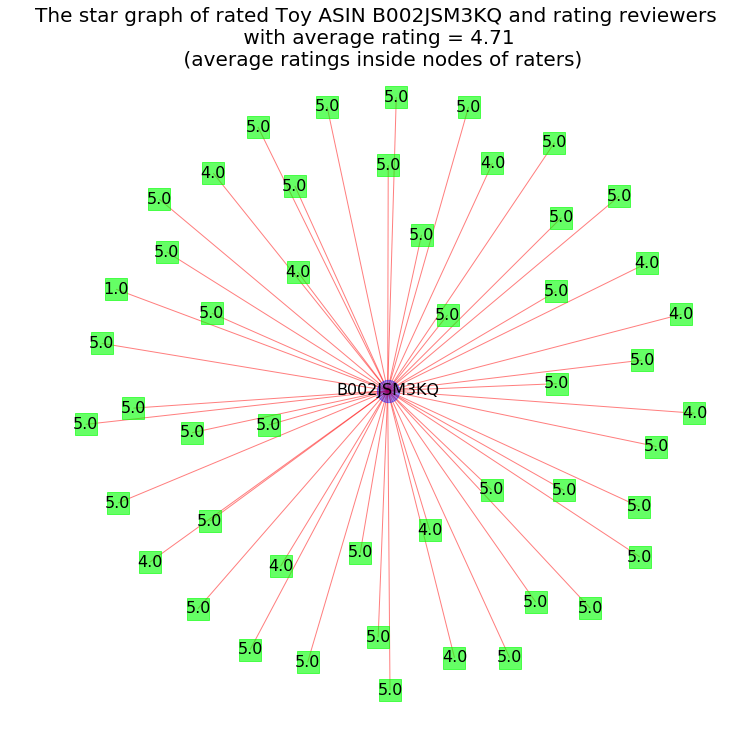

In [56]:
H0=H.subgraph(list(H.neighbors(n0))+[n0])
ara=sum(rn0.values())/float(len(rn0))
labels={}
for i in H0.nodes():
    if i!=n0:
        labels[i]=rn0[i]
    else:
        labels[i]=i
fig = plt.figure(figsize=(12,12))
pos=graphviz_layout(H0)
nx.draw_networkx_nodes(H0,pos=pos,nodelist=[n0],node_color='b',node_size=500,font_size=20,alpha=0.4);
nx.draw_networkx_nodes(H0,pos=pos,nodelist=list(H.neighbors(n0)),node_color='lime',node_shape="s",node_size=500,font_size=20,alpha=0.6);
nx.draw_networkx_edges(H0,pos=pos,edge_color='r',alpha=0.5);
nx.draw_networkx_labels(H0,pos=pos,labels=labels,font_size=16);
sst="The star graph of rated Toy ASIN %s and rating reviewers \n with average rating = %.2f \n (average ratings inside nodes of raters)" %(n0,ara)
fig.suptitle(sst,x=0.5, y=.95, fontsize=20);
plt.axis('off');

### Toy ASINS rated by a reviewer

### Reviewers rating a toy

In [57]:
while True:
    n1=random.choice(gus)  
    rn1={}
    gu1=df.loc[df.reviewerID==n1].groupby(['asin','overall'])
    for name,group in gu1:
        l=group.overall.tolist()
        rn1[name[0]] = sum(l) / float(len(l))
    ara=sum(rn1.values())/float(len(rn1))
    if ara!=0 and H.degree(n1)<50 and H.degree(n1)>15:
        break
print n1,H.degree(n1) 


A15JPYV0L19RF 46


In [58]:
#retrieve the name of the reviewer for use in title of graph
rrr=df.loc[df.reviewerID==n1]
rrr.iloc[0]['reviewerName']

'R. J. Gutt "Tigercat"'

In [59]:
# This dictionary has keys n1's neighbors (i.e., rated asins) 
# and values their average ratings

rn1={}
gu1=df.loc[df.reviewerID==n1].groupby(['asin','overall'])
for name,group in gu1:
    l=group.overall.tolist()
    rn1[name[0]] = sum(l) / float(len(l))
rn1

{'0786958731': 5.0,
 '0984608028': 5.0,
 '158994206X': 5.0,
 '1589942108': 5.0,
 '1589946634': 5.0,
 '193611237X': 5.0,
 'B00000JS5S': 4.0,
 'B00005UFC1': 5.0,
 'B0002HZSQW': 5.0,
 'B0002HZSRQ': 5.0,
 'B00061MJZ2': 4.0,
 'B0007R4J30': 5.0,
 'B000G99IJY': 4.0,
 'B000HSXAJ8': 5.0,
 'B000M8H8Y6': 5.0,
 'B000THI32Q': 5.0,
 'B00115YMWA': 5.0,
 'B00143YK12': 4.0,
 'B0015INKYO': 5.0,
 'B0015IPGB4': 5.0,
 'B001AITZXY': 5.0,
 'B001DQY9WA': 5.0,
 'B001HA9JOA': 5.0,
 'B001Q0XB6S': 5.0,
 'B001SN8GD6': 5.0,
 'B002KIOPEC': 5.0,
 'B002X98IR8': 4.0,
 'B002YDNN8W': 5.0,
 'B0032O6TTW': 5.0,
 'B0033RVDVC': 5.0,
 'B00362TR2Q': 5.0,
 'B00366YWFY': 5.0,
 'B003MPDJ62': 5.0,
 'B003R1V90Y': 5.0,
 'B003U0O3B4': 5.0,
 'B004GW3CAI': 5.0,
 'B004I28EAY': 5.0,
 'B004I2FPYM': 5.0,
 'B005XVCR48': 4.0,
 'B006HEIK6Y': 5.0,
 'B006L7KIWG': 5.0,
 'B007EZM85O': 5.0,
 'B00875JE0C': 5.0,
 'B00A4KHEK0': 5.0,
 'B00B0FTXN4': 5.0,
 'B00E3S8IZ4': 5.0}

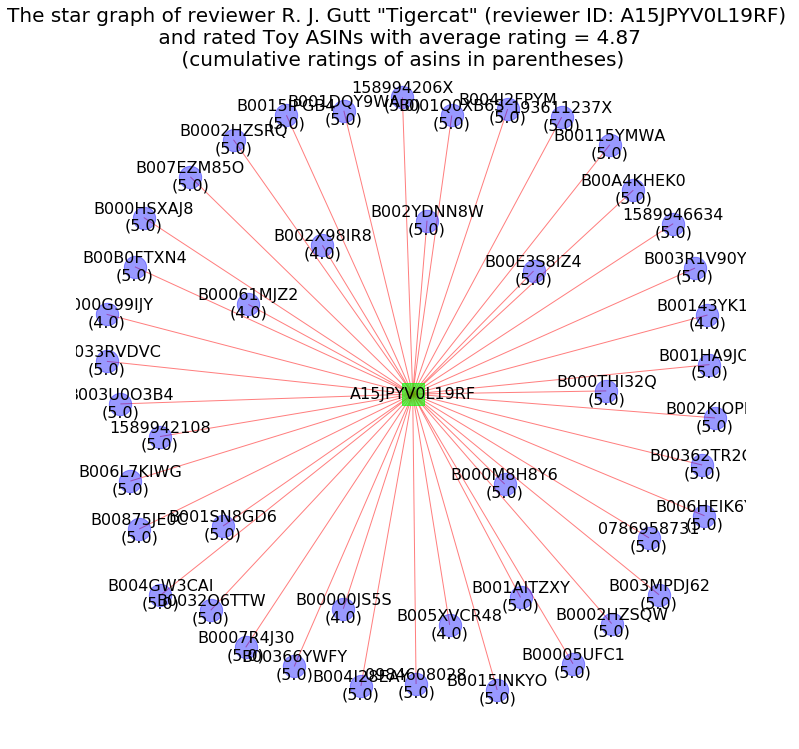

In [60]:
H1=H.subgraph(list(H.neighbors(n1))+[n1])
ara=sum(rn1.values())/float(len(rn1))
labels={}
for i in H1.nodes():
#     labels[i]=i
    if i!=n1:
        labels[i]=unicode(i)+"\n"+"("+str(rn1[i])+")"
    else:
        labels[i]=i
fig = plt.figure(figsize=(12,12))
pos=nx.spring_layout(H1,1.)  #graphviz_layout(H1)
nx.draw_networkx_nodes(H1,pos=pos,nodelist=[n1],node_color='lime',node_shape="s",node_size=500,font_size=20,alpha=0.6);
nx.draw_networkx_nodes(H1,pos=pos,nodelist=list(H.neighbors(n1)),node_color='b',node_size=500,font_size=20,alpha=0.4);
nx.draw_networkx_edges(H1,pos=pos,edge_color='r',alpha=0.5);
nx.draw_networkx_labels(H1,pos=pos,labels=labels,font_size=16);
sst="The star graph of reviewer %s (reviewer ID: %s) \n and rated Toy ASINs with average rating = %.2f \n (cumulative ratings of asins in parentheses)" %(rrr.iloc[0]['reviewerName'],n1,ara)
fig.suptitle(sst,x=0.5, y=.95, fontsize=20);
plt.axis('off');

### 7. The Graph of Co-Rated Toy ASINs by Common Reviewers

**Again this graph is very large and it would be impossible to be plotted with NetworkX. However, one can focus on the toys of a particular group of toy ASINS and construct the graph of co-rated toy ASINS within this group.**

In [75]:
gm=300 # number of random asins

while True:
    pau=random.sample(asins,gm)
    pau=[a.title() for a in pau]
    pau=[p for p in pau if '"\"' not in pau]
    df1=df.loc[df['asin'].isin(pau)]
    gu=df1[['reviewerID','asin','overall']].groupby('reviewerID')
    ubd={}
    for user, data in gu:
        bau=data.asin.unique()
        ubd[user]=len(bau)
    if max(ubd.values())>2:
        break

In [76]:
print len(pau),pau

300 ['B005Jxb81S', 'B000Lfsqsc', 'B007Bsyavy', 'B000060Nqv', 'B00627Is5Y', 'B000U66Ybi', 'B0083Txzca', 'B000Bx4Tto', 'B0000936Kz', 'B0006Ndbxy', 'B0048Eksla', 'B005Vprfpm', 'B002Rl7Vs4', 'B0030Gtzei', 'B003526C8O', '1589947061', 'B0090H0Rk2', 'B00859Gjwq', 'B003Expdac', 'B001U5R1Y2', 'B000E9Dpcw', 'B00Brcnae8', 'B002Eqyi2Y', 'B004Xodioe', 'B002Kdxnhw', 'B004Ors0Ji', 'B008B68Itk', 'B004Oa7Zh8', 'B00Abdzuow', 'B005Kje9L2', 'B002Mnwesy', 'B001O271Yg', 'B005Vpreje', 'B002U4Ph2K', 'B00A8Hox4E', 'B00C6Prqpo', 'B00Dy09Be4', 'B000L7Egma', 'B00000J421', 'B0000Dj3E1', 'B0081D76Ve', 'B007L7Sxju', '0980223644', 'B000Mwb730', 'B000Gr75Sc', '1589781244', 'B00857Sru0', 'B00Cfwwd6A', 'B007App1No', '073533417X', 'B009Euuyyy', 'B006Cd3844', 'B000Acytzk', 'B000Hiir2I', 'B002Ipgxtm', 'B0000Dzcrt', 'B0060L6Ee4', '1616615354', 'B005R1Rzuk', '157982269X', 'B0001Vv534', 'B0040Mk48W', 'B008Ftf9Po', 'B0059L4S3U', 'B005Jr5Rca', 'B004Fpbbsg', 'B000Ov8C6E', 'B006Bma0Lk', 'B00008Pw0J', 'B005J5Ml2Q', 'B007Hvhoao', '

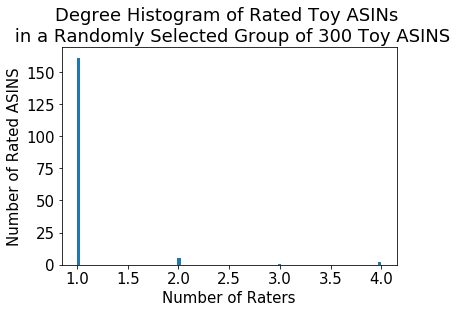

In [77]:
df1=df.loc[df['asin'].isin(pau)]
gu=df1[['reviewerName','asin','overall']].groupby('reviewerName')
ubd={}
for user, data in gu:
    bau=data.asin.unique()
    ubd[user]=len(bau)
fbr=[x for x in ubd.values()]
hist(fbr,bins=100);
plt.xlabel("Number of Raters");
plt.ylabel("Number of Rated ASINS");
sst="Degree Histogram of Rated Toy ASINs \n in a Randomly Selected Group of %i Toy ASINS" %gm
plt.title(sst);

In [78]:
# This dictionary has keys neighbors (i.e., rated asins) 
# of asins in the selected group and values their average ratings

rn11={}
gu11=df1.groupby(['asin','overall'])
for name,group in gu11:
    l=group.overall.tolist()
    rn11[name[0]] = sum(l) / float(len(l))
print len(rn11)
df11=pd.DataFrame({'Toy ASIN':rn11.keys(),'Rating':rn11.values()})
df11

25


,Rating,Toy ASIN
0,3.0,B003526C8O
1,5.0,073533417X
2,5.0,0980223644
3,5.0,B007Y9N5P2
4,5.0,B00004U3E3
5,5.0,B00000J421
6,5.0,B00004R8K3
7,5.0,B001U5R1Y2
8,5.0,B003S7J26U
9,5.0,B002L16L68


In [79]:
edges0=[]
for user, data in gu:
    bau=data.asin.unique()
    jj=list(itertools.combinations(bau,2))
    for j in jj:
        edges0.append(j)
print len(edges0),len(set(edges0))
edges0
G = nx.Graph()
for k,v in dict(Counter(edges0)).items():
    G.add_edge(k[0],k[1],weight=v)
name="Co-Rated ASINS"
first_diagn(G,name)
graph_connectedness_check(G)

20 20
The graph of Co-Rated ASINS has 17 nodes and 20 edges
This graph is not connected and the number of connected components = 4
The largest conected component of this graph has 9 nodes and 14 edges


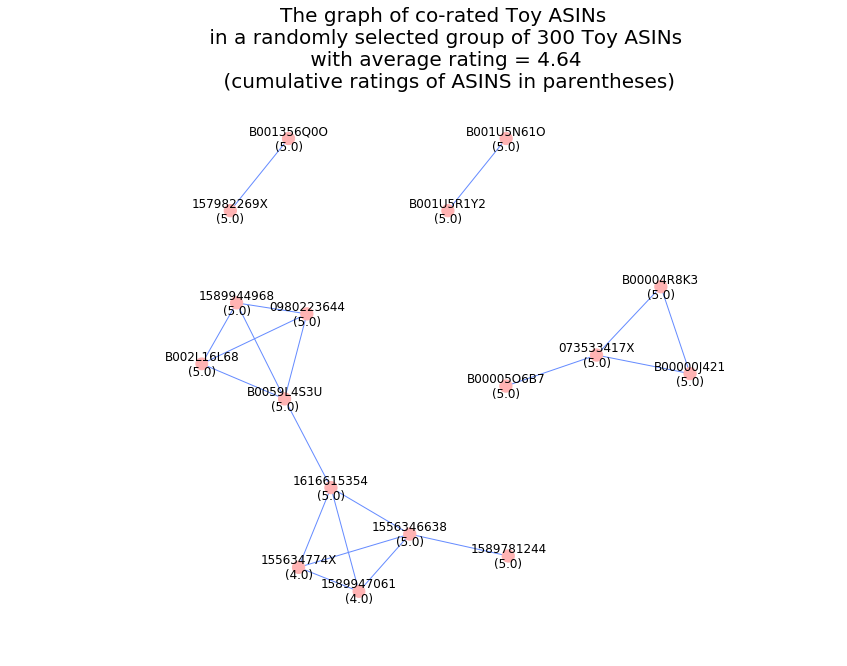

In [80]:
edge_width=[G[u][v]['weight'] for u,v in G.edges()]
# elabels = nx.get_edge_attributes(Gw,'weight')
edge_width=[w for w in edge_width] 
# [math.log(1+w) for w in edge_width]
# [3*w for w in edge_width] 

ara=sum(rn11.values())/float(len(rn11))
labels={}
for i in G.nodes():
    labels[i]=unicode(i)+"\n"+"("+str(rn11[i])+")"

node_size={} 
for i in G.nodes():
    node_size[i]=100+10*rn11[i]
    
figsize=(14,10)
pos=graphviz_layout(G) 
node_color="#ffb3b3"
# node_border_color="grey"
edge_color="#668cff"
# G=Gw

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(G, pos,node_color=node_color,node_size=node_size.values())
# nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width) #,a=0.8)
nx.draw_networkx_labels(G, pos,labels=labels)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
# yoffset = {}
# y_off = -10 #0.05  # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset,labels=labels,font_size=14);
sst="The graph of co-rated Toy ASINs \n in a randomly selected group of %i Toy ASINs \n with average rating = %.2f \n (cumulative ratings of ASINS in parentheses)" %(gm,ara)
# sst="The star graph of user %s and rated authors \n with average rating = %.2f \n (cumulative ratings of authors in parentheses)" %(n1,ara)
plt.title(sst,fontsize=20);
plt.margins(x=0.3, y=0.1) 

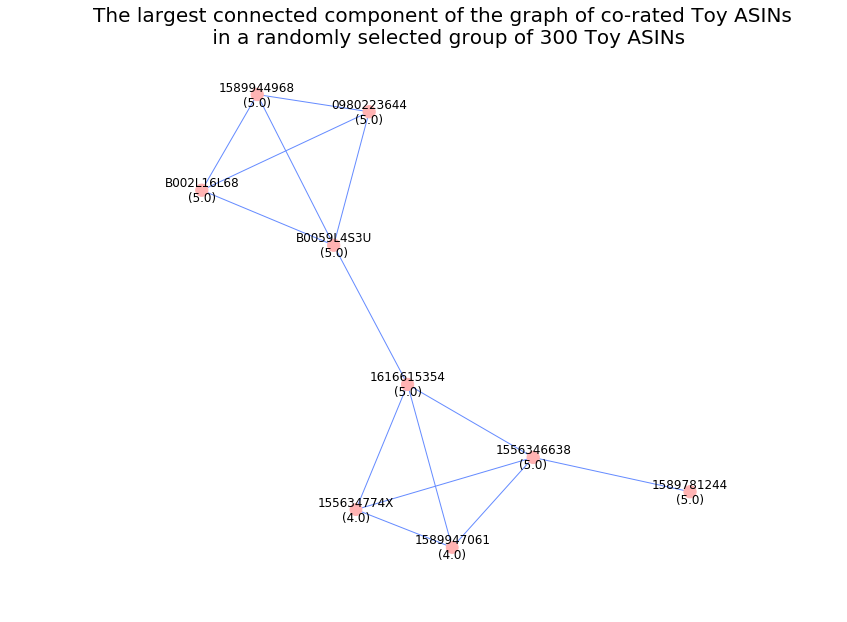

In [81]:
# The larget connected component of the previous graph 
# If the graph is connected, this will be the same as the previous graph

Gl=max(nx.connected_component_subgraphs(G), key=len)
G=Gl
labels={}
for i in G.nodes():
    labels[i]=unicode(i)+"\n"+"("+str(rn11[i])+")"
node_size={} 
for i in G.nodes():
    node_size[i]=100+10*rn11[i]
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(G, pos,node_color=node_color,node_size=node_size.values())
# nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width) #,a=0.8)
nx.draw_networkx_labels(G, pos,labels=labels)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
# yoffset = {}
# y_off = -10 #0.05  # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset,font_size=14);
sst="The largest connected component of the graph of co-rated Toy ASINs \n in a randomly selected group of %i Toy ASINs" %gm
plt.title(sst,fontsize=20);
plt.margins(x=0.3, y=0.1)